In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

In [252]:
# Read Data
df_total = pd.read_csv('AF.csv')
df_total['Period'] = pd.to_datetime(df_total['Period'], format = '%m/%d/%Y')
df = df_total[['Period', 'CCI', 'National TV GRPs', 'Magazine GRPs',
       'Paid Search', 'Display', 'Facebook Impressions', 'Wechat',
       'Sales Event', 'Black Friday', 'July 4th', 'Comp Media Spend', 'Sales']]
df.head()

,Period,CCI,National TV GRPs,Magazine GRPs,Paid Search,Display,Facebook Impressions,Wechat,Sales Event,Black Friday,July 4th,Comp Media Spend,Sales
0,2014-01-06,81.2,82,15,322562,36699907,10912086,451,0,0,0,30331,191228
1,2014-01-13,81.2,72,15,287279,37155907,10231860,462,0,0,0,30331,200741
2,2014-01-20,81.2,82,15,298089,41136934,9519178,558,0,0,0,30331,214381
3,2014-01-27,81.6,80,20,393145,39993325,3705699,507,0,0,0,30331,222694
4,2014-02-03,81.6,62,20,407856,41066571,9695603,609,0,0,0,25199,224297


# Transform

In [253]:
transform = {'National TV GRPs':     {'lag':1, 'Alpha':0.3, 'Decay':0.8}, 
             'Magazine GRPs':        {'lag':1, 'Alpha':0.1, 'Decay':0.7},
             'Paid Search':          {'lag':0, 'Alpha':0.99, 'Decay':0.99}, 
             'Display':              {'lag':0, 'Alpha':1  , 'Decay':1  }, 
             'Facebook Impressions': {'lag':0, 'Alpha':0.7, 'Decay':1  }, 
             'Wechat':               {'lag':1, 'Alpha':1  , 'Decay':0.9}}

In [254]:
def decay_func(s1, decay):
    l = []
    for i in range(len(s1)):
        if i == 0:
            res = s1[i]*decay 
        else:
            res = s1[i]*decay + l[-1]*(1-decay)
        l.append(res)
    return pd.Series(l)

for col in transform:
    #get lag, power, decay
    lag = transform[col]['lag']
    power = transform[col]['Alpha']
    decay = transform[col]['Decay'] 
    
    # performa lag, power, decay
    lag_res = df[col].shift(lag).fillna(0)
    power_res = np.power(lag_res, power)
    decay_res = decay_func(power_res, decay)
    df[col] = decay_res

C:\Users\ruiya\Anaconda3\python\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [255]:
# df

# Build Model

In [256]:
X = df[['CCI', 'National TV GRPs', 'Magazine GRPs',
       'Paid Search', 'Display', 'Facebook Impressions', 'Wechat',
       'Sales Event', 'Black Friday', 'July 4th', 'Comp Media Spend']]
y = df['Sales']
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     622.9
Date:                Sat, 11 Jul 2020   Prob (F-statistic):          5.94e-146
Time:                        13:39:50   Log-Likelihood:                -2152.0
No. Observations:                 208   AIC:                             4328.
Df Residuals:                     196   BIC:                             4368.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  1.49e+05    1.4e+04     10.660      0.000    1.21e+05    1.77e+05
CCI                    225.2033    121.617      1.852      0.066     -14.642     465.049
National TV GRPs      6701.3943   1694.373      3.955      0.000    3359.852       1e+04
Magazine GRPs         6809.9568   1044.365      6.521      0.000    4750.322    8869.591
Paid Search              0.0562      0.014      3.909      0.000       0.028       0.085
Display                  0.0003      0.000      1.819      0.071   -2.39e-05       0.001
Facebook Impressions     0.0623      0.009      7.234      0.000       0.045       0.079
Wechat                   4.8324      1.018      4.749      0.000       2.826       6.839
Sales Event           2.912e+04   1637.636     17.779      0.000    2.59e+04    3.23e+04
Black Friday          2.217e+05   4913.672     45.121      0.000    2.12e+05    2.31e+05
July 4th              1.182e+05   4152.063     28.472      0.000     1.1e+05    1.26e+05
Comp Media Spend        -0.4948      0.082     -6.061      0.000      -0.656      -0.334
==============================================================================
Omnibus:                       97.769   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              995.086
Skew:                           1.506   Prob(JB):                    8.31e-217
Kurtosis:                      13.283   Cond. No.                     1.02e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [262]:
# Contribution
contribution = pd.DataFrame(np.dot(X.values, np.diag(model.params)), columns = ['Intercept','CCI', 'National TV GRPs', 'Magazine GRPs',
       'Paid Search', 'Display', 'Facebook Impressions', 'Wechat',
       'Sales Event', 'Black Friday', 'July 4th', 'Comp Media Spend'])
contribution['Period'] = df['Period']

contribution_long = pd.melt(contribution, 'Period')


def mapping_func(n):
    if n in ['Black Friday','CCI','Comp Media Spend','Intercept','Sales Event','July 4th']:
        return 'Base'
    else:
        return n
contribution_long['variable'] = pd.Series(contribution_long['variable']).apply(lambda x: mapping_func(x))


contribution_groupby = contribution_long.groupby('variable')['value'].sum()
contribution_pct = contribution_groupby / sum(contribution_groupby)
pd.DataFrame(contribution_pct).sort_values('value', ascending=False)

,value
variable,
Base,0.703231
National TV GRPs,0.092393
Paid Search,0.072155
Display,0.045911
Facebook Impressions,0.031044
Wechat,0.028099
Magazine GRPs,0.027167


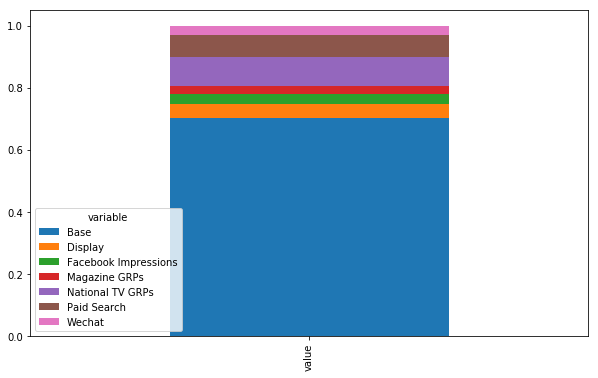

In [259]:
pd.DataFrame(contribution_pct).T.plot(kind='bar', stacked=True, figsize=(10,6))

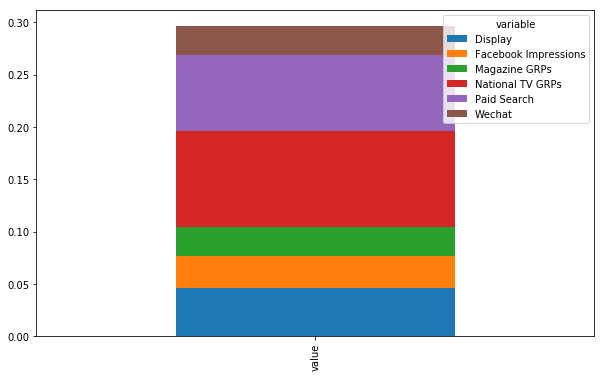

In [260]:
pd.DataFrame(contribution_pct).sort_values('value', ascending=True).T[['Display', 'Facebook Impressions', 'Magazine GRPs',
       'National TV GRPs', 'Paid Search', 'Wechat']].plot(kind='bar', stacked=True, figsize=(10,6))

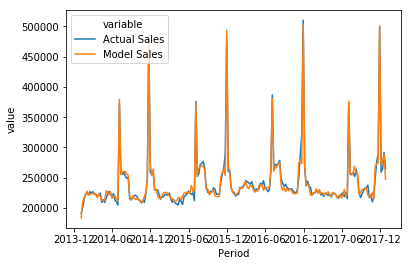

In [261]:
# AVM
AVM = pd.DataFrame({'Period':df['Period'], 'Actual Sales': df['Sales'], 'Model Sales':model.predict()})

sns.lineplot(y='value',x='Period', hue = 'variable', data=pd.melt(AVM, 'Period'))

In [280]:
activity_spend = pd.read_csv('Activity and Spend.csv')
activity_spend['Period'] = pd.to_datetime(activity_spend['Period'], format = '%m/%d/%Y')
activity_spend.variable.unique()

array(['National TV GRPs', 'Magazine GRPs', 'Paid Search', 'Display',
       'Facebook Impressions', 'Wechat'], dtype=object)

In [281]:
contribution_long['variable'].unique()

array(['Base', 'National TV GRPs', 'Magazine GRPs', 'Paid Search',
       'Display', 'Facebook Impressions', 'Wechat'], dtype=object)

In [288]:
join_table = pd.merge(contribution_long, activity_spend, on = ['Period','variable'], how = 'left')

# Side Model

In [292]:
side = pd.read_csv("Data for Side Model.csv")
side['Period'] = pd.to_datetime(side['Period'], format = '%m/%d/%Y')
side.columns

Index(['Period', 'DisplayAlwaysOnImpression', 'DisplayBrandingImpression',
       'DisplayWebsiteImpression', 'DisplayHolidayImpression',
       'SearchBrandingclicks', 'SearchAlwasyOnclicks', 'SearchWebsiteclicks',
       'FacebookBrandingImpressions', 'FacebookHolidayImpressions',
       'FacebookOtherImpressions', 'DisplayAlwaysOnSpend',
       'DisplayBrandingSpend', 'DisplayWebsiteSpend', 'DisplayHolidaySpend',
       'SearchBrandingSpend', 'SearchAlwasyOnSpend', 'SearchWebsiteSpend',
       'FacebookBrandingSpend', 'FacebookHolidaySpend', 'FacebookOtherSpend'],
      dtype='object')

In [294]:
contribution.head()

,Intercept,CCI,National TV GRPs,Magazine GRPs,Paid Search,Display,Facebook Impressions,Wechat,Sales Event,Black Friday,July 4th,Comp Media Spend,Period
0,148988.136081,18286.508082,0.000000,0.000000,15801.810268,10372.607984,5263.560352,0.000000,0.0,0.0,0.0,-15006.683817,2014-01-06
1,148988.136081,18286.508082,20109.409415,6249.589899,14247.681351,10501.488671,5031.672583,1961.486761,0.0,0.0,0.0,-15006.683817,2014-01-13
2,148988.136081,18286.508082,23361.812397,8124.466869,14756.919632,11626.658619,4783.698220,2205.476577,0.0,0.0,0.0,-15006.683817,2014-01-20
3,148988.136081,18376.589403,24781.771895,8686.929960,19369.057022,11303.436878,2471.458140,2647.398240,0.0,0.0,0.0,-15006.683817,2014-01-27
4,148988.136081,18376.589403,24917.348032,9038.069474,20127.098697,11606.771707,4845.588589,2469.781482,0.0,0.0,0.0,-12467.555488,2014-02-03


In [351]:
# Group1-Facebook
# x_col = ['FacebookBrandingImpressions', 'FacebookHolidayImpressions', 'FacebookOtherImpressions']
# y_col = 'Facebook Impressions'
# spend_col = ['FacebookBrandingSpend', 'FacebookHolidaySpend', 'FacebookOtherSpend']


# Group2-Display
# x_col = ['DisplayAlwaysOnImpression', 'DisplayBrandingImpression', 'DisplayWebsiteImpression', 'DisplayHolidayImpression']
# y_col = 'Display'
# spend_col = ['DisplayAlwaysOnSpend', 'DisplayBrandingSpend', 'DisplayWebsiteSpend', 'DisplayHolidaySpend']


# Group3-Display
x_col = ['SearchBrandingclicks', 'SearchAlwasyOnclicks', 'SearchWebsiteclicks']
y_col = 'Paid Search'
spend_col = ['SearchBrandingSpend', 'SearchAlwasyOnSpend', 'SearchWebsiteSpend']




side_temp = side[['Period'] + x_col]
side_temp['contribution'] = contribution[y_col]
side_temp

C:\Users\ruiya\Anaconda3\python\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Period,SearchBrandingclicks,SearchAlwasyOnclicks,SearchWebsiteclicks,contribution
0,2014-01-06,103017,164915,54630,15801.810268
1,2014-01-13,74678,108301,104300,14247.681351
2,2014-01-20,76437,133055,88597,14756.919632
3,2014-01-27,82677,178666,131802,19369.057022
4,2014-02-03,88491,250863,68502,20127.098697
5,2014-02-10,98239,162350,87056,17219.109547
6,2014-02-17,47941,194609,106774,17271.395818
7,2014-02-24,68944,194390,85462,17246.331650
8,2014-03-03,87823,175811,102698,18095.676903
9,2014-03-10,99707,188083,86423,18485.860689


In [352]:
y = side_temp['contribution']
X = side_temp[x_col]
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           contribution   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.367e+06
Date:                Sat, 11 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:12:28   Log-Likelihood:                -1109.2
No. Observations:                 208   AIC:                             2224.
Df Residuals:                     205   BIC:                             2234.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
SearchBrandingclicks     0.0494   6.69e-05    739.245      0.000       0.049       0.050
SearchAlwasyOnclicks     0.0494   5.26e-05    939.997      0.000       0.049       0.050
SearchWebsiteclicks      0.0494   7.86e-05    629.019      0.000       0.049       0.050
==============================================================================
Omnibus:                       11.054   Durbin-Watson:                   2.768
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.263
Skew:                          -0.545   Prob(JB):                      0.00358
Kurtosis:                       3.337   Cond. No.                         5.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [353]:
s_coefficient = model.params
index = s_coefficient.index

side_contribution = pd.DataFrame(np.dot(X.values, np.diag(model.params)), columns = x_col)
s_contri = side_contribution.sum()

s_activity = side_temp[x_col].sum()

s_spend = side[spend_col].sum()

s_efficiency = s_contri.divide(s_spend.values)

s_effectivess = s_contri.divide(s_activity)

s_result = pd.DataFrame([s_coefficient.reset_index(drop=True),s_contri.reset_index(drop=True),s_activity.reset_index(drop=True),s_spend.reset_index(drop=True), s_efficiency.reset_index(drop=True), s_effectivess.reset_index(drop=True)])
s_result.columns = [index]
s_result.index = ['Coefficient','Contribution','Activity','Spend','Efficiency','Effectiveness']
s_result

,SearchBrandingclicks,SearchAlwasyOnclicks,SearchWebsiteclicks
Coefficient,4.942243e-02,4.941431e-02,4.942529e-02
Contribution,1.050625e+06,1.849873e+06,7.150603e+05
Activity,2.125805e+07,3.743598e+07,1.446750e+07
Spend,2.158430e+05,4.151630e+05,2.141870e+05
Efficiency,4.867541e+00,4.455775e+00,3.338486e+00
Effectiveness,4.942243e-02,4.941431e-02,4.942529e-02


In [354]:
# contribution_long.to_csv('contribution.csv')

# AVM.to_csv('AVM.csv')

# join_table.to_csv('join.csv')

s_result.to_csv('side Paid Search.csv')